# AB Test Assigment

In [26]:
# AB Test Assigment
# Author: Klara Martinaskova
# Task: Evaluate an AB test of the recommendation algorithm

In [27]:
#!/usr/bin/env python3.9
# coding=utf-8

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pingouin as pg
from datetime import datetime

#### Loadning data

In [28]:
# Open csv file ans save as dataframe
df_clients = pd.read_csv(
    "clients_final.csv", encoding="cp1250", sep=",", low_memory=False)
df_orders = pd.read_csv(
    "orders_final.csv", encoding="cp1250", sep=",", low_memory=False)

#### First check ab User

###### There is the problem, because in the according to the assignment there should be the number 99, but after checking I find that there is NaN.

In [29]:
# Analysis of abUser column
# 99 is not present here (just NaN)
abUser_unique = df_clients["abUser"].unique()
txt = "Unique values in abUser: {}"
print(txt.format(abUser_unique))

Unique values in abUser: [ 1.  2. nan]


#### Devided into groups

In [30]:
# Devided into two groups by country
df_clients_ch = df_clients[df_clients["country"] == "CH"]
df_clients_ne = df_clients[df_clients["country"] == "NE"]

df_orders_ch = df_orders[df_orders["country"] == "CH"]
df_orders_ne = df_orders[df_orders["country"] == "NE"]

#### Filtering data

In [31]:
# Check the date
# Is the test running for the correct period?

def filter_by_period(df, start_date, end_date):
    df["date"] = pd.to_datetime(df["date"])
    filtered_df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    filtered_df["date"] = filtered_df["date"].dt.strftime("%Y-%m-%d")
    return filtered_df


start_date = datetime(2023, 5, 17)
end_date = datetime(2023, 6, 16)

df_clients_ch = filter_by_period(
    df_clients_ch, start_date, end_date)  # data in correct period
df_clients_ne = filter_by_period(
    df_clients_ne, start_date, end_date)  # data in correct period

C:\Users\klara\AppData\Local\Temp\ipykernel_21004\1692912779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])
C:\Users\klara\AppData\Local\Temp\ipykernel_21004\1692912779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["date"] = filtered_df["date"].dt.strftime("%Y-%m-%d")
C:\Users\klara\AppData\Local\Temp\ipykernel_21004\1692912779.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

###### To analyze the abUser group, I will need unique clientID records so I can compare the correct assignment ratio. 
###### I will also need all the data so that I don't lose the records with non-unique clientID, I will save the original data as well.

In [32]:
# Select only unique clientID
# Sort dataframe by date
df_clients_ch = df_clients_ch.sort_values(by=["date"])
df_clients_ne = df_clients_ne.sort_values(by=["date"])

# Save raw data
df_clients_ch_raw = df_clients_ch.copy()
df_clients_ne_raw = df_clients_ne.copy()

# Drop duplicated client id and keep the first one
df_clients_ch = df_clients_ch.drop_duplicates(
    subset=["clientID"], keep="first")
df_clients_ne = df_clients_ne.drop_duplicates(
    subset=["clientID"], keep="first")

###### I want to delete redundant data. (Not needed in this particular data set.)

In [33]:
# Delete duplicates and NaN in orders

df_orders_ch = df_orders_ch.drop_duplicates(
    subset=["orderNumber"], keep="first")  # drop duplicates
df_orders_ch = df_orders_ch.dropna(subset=["orderNumber"])  # drop NaN

df_orders_ne = df_orders_ne.drop_duplicates(
    subset=["orderNumber"], keep="first")  # drop duplicates
df_orders_ne = df_orders_ne.dropna(subset=["orderNumber"])  # drop NaN

### Reco and control group 50:50 testing

##### Task:

###### Is the ratio of users in the reco group and users in the test group really 50:50? 
###### Can you test it by an appropriate statistical test? 
######  Do you prefer to test it on a daily basis, or to run one test for the whole period? 
######  If you run multiple tests, do you need all of them to have positive results to verify the 50:50 distribution hypothesis? 



##### Answers:

###### No, the  ration of users in reco group and is the test group is really not 50:50. 
###### Here is an explanation:
###### -	I tested the data distribution for each day and also for the whole period. 
###### -	Not a single suitable distribution was found for the country CH, nor within each day. 
###### -	For the NE country, two suitable distributions were found within each day, the remaining days were not suitably distributed and the overall test also came out negative. 
###### -	I used a binomial test.
###### -	It is not necessary for all partial results to be positive for an overall positive test.


In [57]:
def binomial_test(df_group1, df_group2, expected_proportion, alt):
    observed_success = len(df_group1)
    total_items = len(df_group1) + len(df_group2)
    return stats.binomtest(observed_success, total_items, expected_proportion, alternative=alt)


def filter_by_day_and_abUser(df, day, abUser):
    return df[(df["date"] == unique_days[day]) & (df["abUser"] == abUser)]


def check_share_of_abUser_each_day(df, unique_days):
    for day in range(len(unique_days)):
        df_current_day_reco = filter_by_day_and_abUser(df, day, 1)
        df_current_day_control = filter_by_day_and_abUser(df, day, 2)
        expected_share = 0.5
        binom = binomial_test(df_current_day_reco,
                              df_current_day_control, expected_share, "two-sided")

        if binom.pvalue < 0.05:
            print(f"\tDay {unique_days[day]} is significant")

In [58]:
# Test for each day
print("Test if the ratio of users in the reco group and users in the test group really 50:50\n")

# CH
unique_days = df_clients_ch["date"].unique()

print("Days with significant p-values for CH (if any): ")
check_share_of_abUser_each_day(df_clients_ch, unique_days)

# NE
unique_days = df_clients_ne["date"].unique()

print("Days with significant p-values for NE (if any): ")
check_share_of_abUser_each_day(df_clients_ne, unique_days)

Test if the ratio of users in the reco group and users in the test group really 50:50

Days with significant p-values for CH (if any): 
Days with significant p-values for NE (if any): 
	Day 2023-05-25 is significant
	Day 2023-05-29 is significant


In [59]:
# Test for whole period
print("Test ration for whole period: ")
share = 0.5

# CH
df_clients_ch_reco = df_clients_ch["abUser"][df_clients_ch["abUser"] == 1]
df_clients_ch_control = df_clients_ch["abUser"][df_clients_ch["abUser"] == 2]

binom_ch = binomial_test(
    df_clients_ch_reco, df_clients_ch_control, share, "two-sided")

print(f"Binomial test for CH: {binom_ch}")

if binom_ch.pvalue < 0.05:
    print("\tThe test is significant")
else:
    print("\tThe test is not significant")

# NE
df_clients_ne_reco = df_clients_ne["abUser"][df_clients_ne["abUser"] == 1]
df_clients_ne_control = df_clients_ne["abUser"][df_clients_ne["abUser"] == 2]

binom_ne = binomial_test(
    df_clients_ne_reco, df_clients_ne_control, share, "two-sided")

print(f"Binomial test for NE: {binom_ne}")

if binom_ne.pvalue < 0.05:
    print("\tThe test is significant")
else:
    print("\tThe test is not significant")

Test ration for whole period: 
Binomial test for CH: BinomTestResult(k=1031241, n=2062236, alternative='two-sided', statistic=0.5000596439980681, pvalue=0.8645327813601438)
	The test is not significant
Binomial test for NE: BinomTestResult(k=227493, n=453869, alternative='two-sided', statistic=0.5012305312766459, pvalue=0.09761471403682057)
	The test is not significant


### Share of users with an unassigned group

##### Task:

###### What about the users with an unassigned group? Bambino thinks the test is fine if their share is below 0.5%.


##### Answers:

###### Share of users with an unassigned group for CH: 
######      The test is not fine, share is 0.59%
###### Share of users with an unassigned group for NE: 
######      The test is not fine, share is 0.53%
###### I checked this task using ratios and a statistical binomial test. Both methods were negative.


In [37]:
df = df_clients_ch
unassigned_count = len(df["abUser"][(df["abUser"] != 1) & (df["abUser"] != 2)])

print("Unassigned count: ", unassigned_count)

Unassigned count:  12206


In [38]:
# First method without statistical test

def unassigned_share(df):
    reco_count = df["abUser"][df["abUser"] == 1].count()
    control_count = df["abUser"][df["abUser"] == 2].count()

    unassigned_count = len(
        df["abUser"][(df["abUser"] != 1) & (df["abUser"] != 2)])
    unnasigned_percent_share = unassigned_count / \
        ((reco_count + control_count + unassigned_count))*100

    if unnasigned_percent_share < 0.5:
        print("\tThe test is fine, share is below 0.5%.")
        print(
            "\tPercent of users with an unassigned group: {:.2f}%".format(unnasigned_percent_share))
    else:
        print("\tThe test is not fine, share is {:.2f}%".format(
            unnasigned_percent_share))
print("Share of users with an unassigned group for CH: ")
unassigned_share(df_clients_ch)

print("Share of users with an unassigned group for NE: ")
unassigned_share(df_clients_ne)

Share of users with an unassigned group for CH: 
	The test is not fine, share is 0.59%
Share of users with an unassigned group for NE: 
	The test is not fine, share is 0.53%


In [39]:
# Second method with statistical test
share_unassigned = 0.005
# CH
assigned_group_ch = df_clients_ch["abUser"][(
    df_clients_ch["abUser"] == 1) | (df_clients_ch["abUser"] == 2)]
unassigned_group_ch = df_clients_ch["abUser"][(
    df_clients_ch["abUser"] != 1) & (df_clients_ch["abUser"] != 2)]
binom_ch = binomial_test(
    unassigned_group_ch, assigned_group_ch, share_unassigned, "less")

print(f"Binomial test for CH: \n\t{binom_ch}")
if binom_ch.pvalue < 0.05:
    print("\tThe test is significant.")
else:
    print("\tThe test is not significant.")

# NE
assigned_group_ne = df_clients_ne["abUser"][(
    df_clients_ne["abUser"] == 1) | (df_clients_ne["abUser"] == 2)]
unassigned_group_ne = df_clients_ne["abUser"][(
    df_clients_ne["abUser"] != 1) & (df_clients_ne["abUser"] != 2)]
binom_ne = binomial_test(
    unassigned_group_ne, assigned_group_ne, share_unassigned, "less")

print(f"Binomial test for NE: \n\t{binom_ne}")
if binom_ne.pvalue < 0.05:
    print("\tThe test is significan.t")
else:
    print("\tThe test is not significant.")

Binomial test for CH: 
	BinomTestResult(k=12206, n=2074442, alternative='less', statistic=0.005883991936144756, pvalue=1.0)
	The test is not significant.
Binomial test for NE: 
	BinomTestResult(k=2398, n=456267, alternative='less', statistic=0.00525569458233885, pvalue=0.9926992491834234)
	The test is not significant.


#### Drop records with unnasigned abUser

In [40]:
# Drop unassigned user record
df_clients_ch = df_clients_ch[(df_clients_ch["abUser"] == 1) | (
    df_clients_ch["abUser"] == 2)]
df_clients_ne = df_clients_ne[(df_clients_ne["abUser"] == 1) | (
    df_clients_ne["abUser"] == 2)]

df_clients_ch_raw = df_clients_ch_raw[(
    df_clients_ch_raw["abUser"] == 1) | (df_clients_ch_raw["abUser"] == 2)]
df_clients_ne_raw = df_clients_ne_raw[(
    df_clients_ne_raw["abUser"] == 1) | (df_clients_ne_raw["abUser"] == 2)]


### Data, which are not in GA data

##### Task:

###### What about the orders that are not in GA data? What is their share? How do you propose to handle them?


##### Answers:

###### Share of orders that are not in GA data for CH: 5.52%
###### Share of orders that are not in GA data for NE: 3.36%
###### These values are for my AB test not relevant any more, so thanks “inner join” I actually drop them.

In [41]:
# CH
df_join_ch = df_clients_ch_raw.merge(
    df_orders_ch, on="orderNumber", how="inner")  # join tables (inner join)
share_orders_not_in_GA_ch = 1 - \
    (len(df_join_ch) / len(df_orders_ch))  # share of orders not in GA

print("Share of orders that are not in GA data for CH: {:.2f}%".format(
    share_orders_not_in_GA_ch * 100))

Share of orders that are not in GA data for CH: 5.52%


In [42]:
# NE
df_join_ne = df_clients_ne_raw.merge(
    df_orders_ne, on="orderNumber", how="inner")  # join tables (inner join)
share_orders_not_in_GA_ne = 1 - \
    (len(df_join_ne) / len(df_orders_ne))  # share of orders not in GA

print("Share of orders that are not in GA data for NE: {:.2f}%".format(
    share_orders_not_in_GA_ne * 100))

Share of orders that are not in GA data for NE: 3.36%


### Test average of reco group for revenue and quantity

##### Task:

###### Does the “reco group” earn, on average, a greater revenue? Does it have larger orders?
###### Propose appropriate metrics and visualize them. Is there any other metric you may wish to evaluate?


##### Answers:

###### Tests for no country show that individual groups have on average higher revenues or larger orders.
###### I used t-test for statistical testing. 
###### You can see the visualization in the attached jupyter file or in the folder “plots” with charts. You can find there:
###### - data distribution within groups, 
###### - outlier detection, 
###### - histograms of occurrence,
###### - visualization of averages


In [43]:
# reco group:  abUser == 1
# control group: abUser == 2

In [44]:
def t_test(group1, group2):
    ttest_result = stats.ttest_ind(a=group1, b=group2, equal_var=True)
    print("\tT-test p-value: ", ttest_result.pvalue)

    if ttest_result.pvalue < 0.05:
        print("\tThe difference between the two groups is statistically significant.")
    else:
        print("\tThe difference between the two groups is not statistically significant.")

In [45]:
# Test for Revenue
print("Test if the “reco group” earn, on average, a greater revenue: ")
# CH
df_reco = df_join_ch["revenue"][df_join_ch["abUser"] == 1]
df_control = df_join_ch["revenue"][df_join_ch["abUser"] == 2]

print("Test for country CH: ")

t_test(df_reco, df_control)

# NE
df_reco = df_join_ne["revenue"][df_join_ne["abUser"] == 1]
df_control = df_join_ne["revenue"][df_join_ne["abUser"] == 2]

print("Test for country NE: ")

t_test(df_reco, df_control)

Test if the “reco group” earn, on average, a greater revenue: 
Test for country CH: 
	T-test p-value:  0.7250289384048942
	The difference between the two groups is not statistically significant.
Test for country NE: 
	T-test p-value:  0.3190449055210245
	The difference between the two groups is not statistically significant.


In [46]:
# Test for Quantity
print("Test if the “reco group” has larger order: ")
# CH
df_reco = df_join_ch["quantity"][df_join_ch["abUser"] == 1]
df_control = df_join_ch["quantity"][df_join_ch["abUser"] == 2]
print("Test for country CH: ")
t_test(df_reco, df_control)

# NE
df_reco = df_join_ne["quantity"][df_join_ne["abUser"] == 1]
df_control = df_join_ne["quantity"][df_join_ne["abUser"] == 2]
print("Test for country NE: ")
t_test(df_reco, df_control)

Test if the “reco group” has larger order: 
Test for country CH: 
	T-test p-value:  0.29631850800304177
	The difference between the two groups is not statistically significant.
Test for country NE: 
	T-test p-value:  0.452535020639812
	The difference between the two groups is not statistically significant.


##### Check the distribution of the data for quantity and revenue

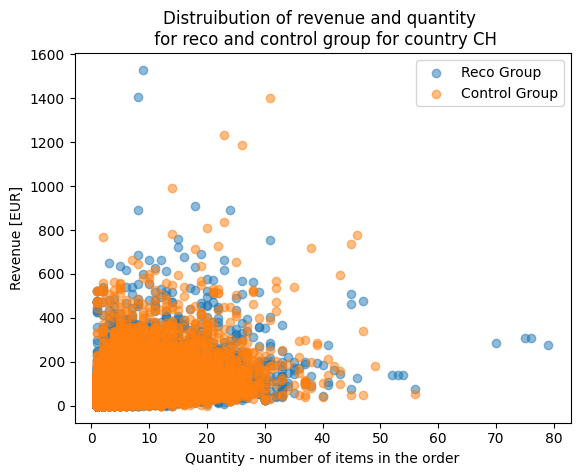

In [47]:
# CH
df_join = df_join_ch
plt.scatter(df_join["quantity"][df_join["abUser"] == 1],
            df_join["revenue"][df_join["abUser"] == 1], alpha=0.5, marker="o")
plt.scatter(df_join["quantity"][df_join["abUser"] == 2],
            df_join["revenue"][df_join["abUser"] == 2], alpha=0.5, marker="o")
plt.xlabel("Quantity - number of items in the order")
plt.ylabel("Revenue [EUR]")
plt.legend(["Reco Group", "Control Group"])
plt.title(
    "Distruibution of revenue and quantity \n for reco and control group for country CH")
plt.show()

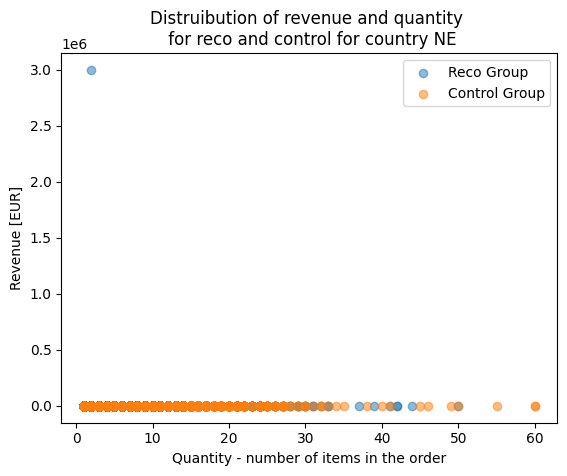

In [48]:
# NE
df_join = df_join_ne
plt.scatter(df_join["quantity"][df_join["abUser"] == 1],
            df_join["revenue"][df_join["abUser"] == 1], alpha=0.5, marker="o")
plt.scatter(df_join["quantity"][df_join["abUser"] == 2],
            df_join["revenue"][df_join["abUser"] == 2], alpha=0.5, marker="o")
plt.xlabel("Quantity - number of items in the order")
plt.ylabel("Revenue [EUR]")
plt.legend(["Reco Group", "Control Group"])
plt.title(
    "Distruibution of revenue and quantity \n for reco and control for country NE")
plt.show()


###### Because I detected outlier, I decided to drop out it.

In [49]:
# Drop outlier from NE dataframe
reco_max = df_join_ne["revenue"][df_join_ne["abUser"] == 1].idxmax()
# df_join_ne_with_outlier = df_join_ne.copy()
df_join_ne = df_join_ne.drop(reco_max)  # redefine dataframe without outlier

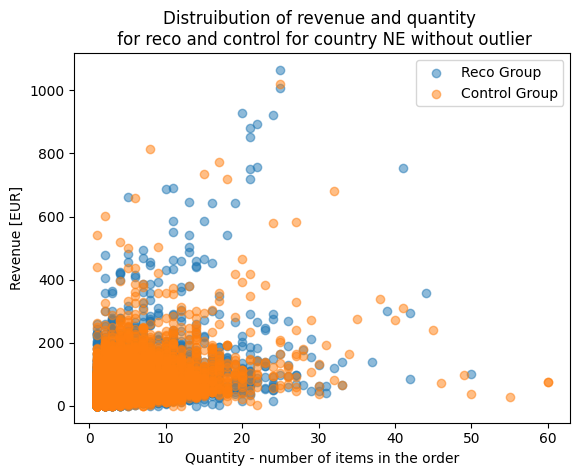

In [50]:
# Plot of distribution without outlier
df_join = df_join_ne
plt.scatter(df_join["quantity"][df_join["abUser"] == 1],
            df_join["revenue"][df_join["abUser"] == 1], alpha=0.5, marker="o")
plt.scatter(df_join["quantity"][df_join["abUser"] == 2],
            df_join["revenue"][df_join["abUser"] == 2], alpha=0.5, marker="o")
plt.xlabel("Quantity - number of items in the order")
plt.ylabel("Revenue [EUR]")
plt.legend(["Reco Group", "Control Group"])
plt.title("Distruibution of revenue and quantity \n for reco and control for country NE without outlier")
plt.show()

##### Boxplots

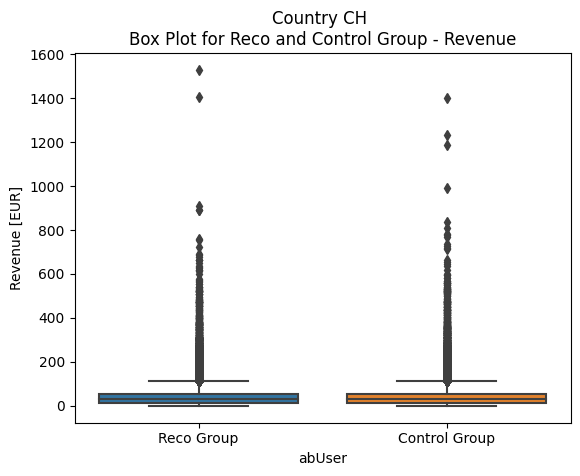

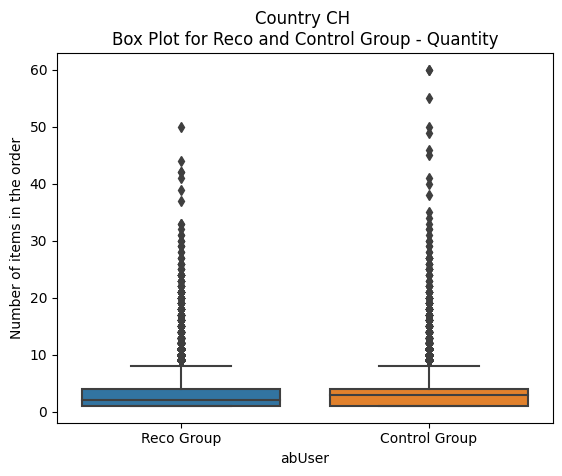

In [51]:
# CH
# Boxplot for revenue
sns.boxplot(data=df_join_ch, x="abUser", y="revenue")
plt.ylabel("Revenue [EUR]")
plt.title("Country CH \nBox Plot for Reco and Control Group - Revenue")
plt.xticks([0, 1], ["Reco Group", "Control Group"])
plt.show()

# Boxplot for quantity
sns.boxplot(data=df_join_ne, x="abUser", y="quantity")
plt.ylabel("Number of items in the order")
plt.title("Country CH \nBox Plot for Reco and Control Group - Quantity")
plt.xticks([0, 1], ["Reco Group", "Control Group"])
plt.show()

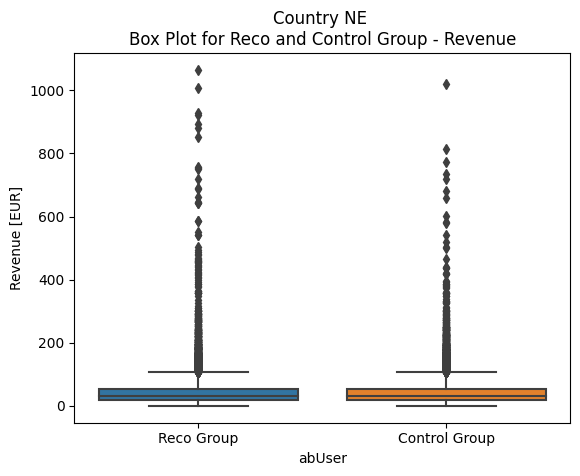

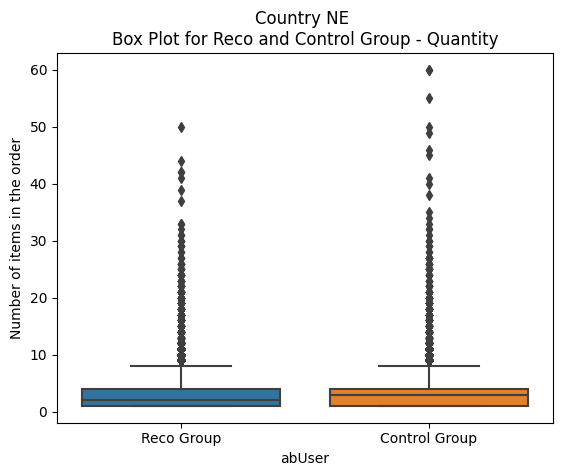

In [52]:
# NE
# Boxplot for revenue
sns.boxplot(data=df_join_ne, x="abUser", y="revenue")
plt.ylabel("Revenue [EUR]")
plt.title("Country NE \nBox Plot for Reco and Control Group - Revenue")
plt.xticks([0, 1], ["Reco Group", "Control Group"])
plt.show()

# Boxplot for quantity
sns.boxplot(data=df_join_ne, x="abUser", y="quantity")
plt.ylabel("Number of items in the order")
plt.title("Country NE \nBox Plot for Reco and Control Group - Quantity")
plt.xticks([0, 1], ["Reco Group", "Control Group"])
plt.show()

##### Histograms - frequency of occurence (CH country)

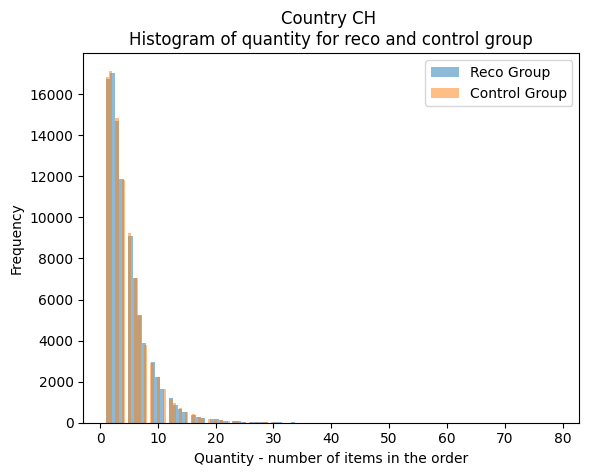

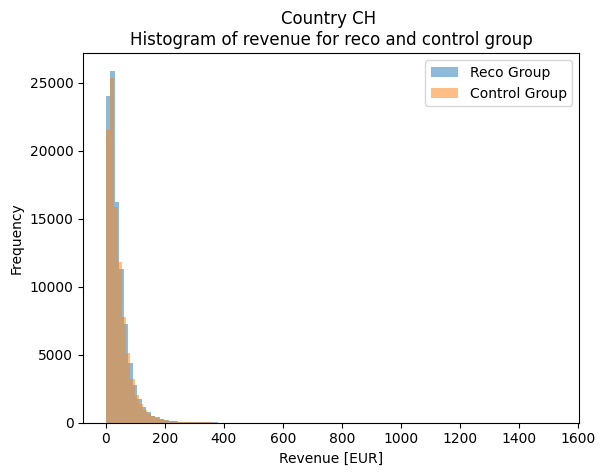

In [53]:
# CH
df_join = df_join_ch

# Histogram for quantity
plt.hist(x=df_join["quantity"][df_join["abUser"] == 1],
         bins=100,  alpha=0.5, label="reco group")
plt.hist(x=df_join["quantity"][df_join["abUser"] == 2],
         bins=100,  alpha=0.5, label="control group")
plt.xlabel("Quantity - number of items in the order")
plt.ylabel("Frequency")
plt.legend(["Reco Group", "Control Group"])
plt.title("Country CH \nHistogram of quantity for reco and control group")
plt.show()

# Histogram for revenue
plt.hist(x=df_join["revenue"][df_join["abUser"] == 1],
         bins=100,  alpha=0.5, label="reco group")
plt.hist(x=df_join["revenue"][df_join["abUser"] == 2],
         bins=100,  alpha=0.5, label="control group")
plt.xlabel("Revenue [EUR]")
plt.ylabel("Frequency")
plt.legend(["Reco Group", "Control Group"])
plt.title("Country CH \nHistogram of revenue for reco and control group")
plt.show()

##### Average item revenue by order size (CH country)

###### Due to the frequency of occurrence, I also visualized the comparison of the two groups for the most frequent number of items in the orders. 

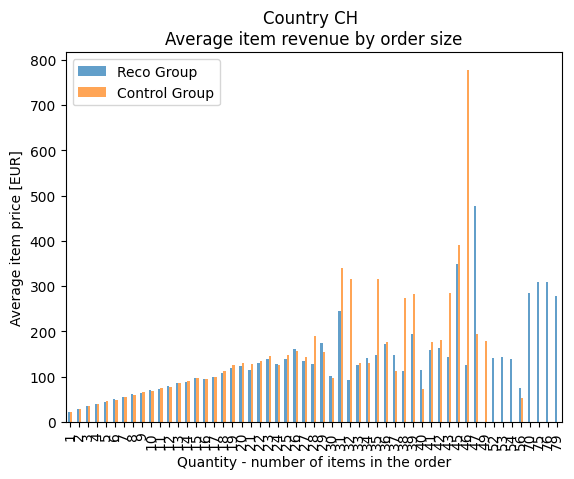

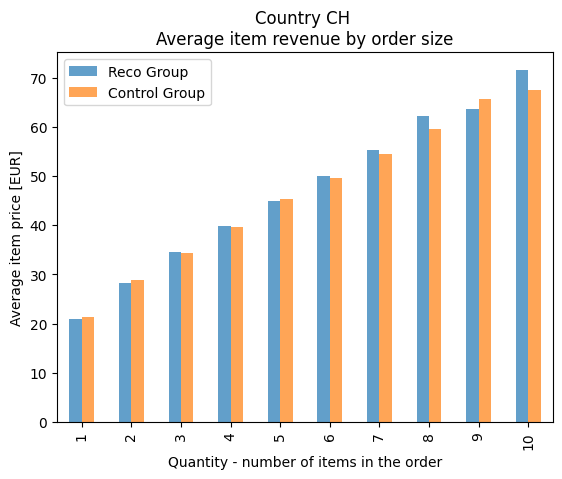

In [54]:
# CH

# Visualization of average revenue by quantity
grouped_data = df_join.groupby(["quantity", "abUser"])[
    "revenue"].mean().unstack()

ax = grouped_data.plot(kind="bar", alpha=0.7)
ax.set_title("Country CH \nAverage item revenue by order size")
ax.set_ylabel("Average item price [EUR]")
ax.set_xlabel("Quantity - number of items in the order")
plt.legend(["Reco Group", "Control Group"])
plt.show()

# Visualization of average revenue by quantity for most common quantity
filtered_df = df_join[df_join["quantity"].between(1, 10)]
grouped_data_filtered = filtered_df.groupby(["quantity", "abUser"])[
    "revenue"].mean().unstack()

ax = grouped_data_filtered.plot(kind="bar", alpha=0.7)
ax.set_title("Country CH \nAverage item revenue by order size")
ax.set_ylabel("Average item price [EUR]")
ax.set_xlabel("Quantity - number of items in the order")
plt.legend(["Reco Group", "Control Group"])
plt.show()

##### Histograms - frequency of occurence (NE country)

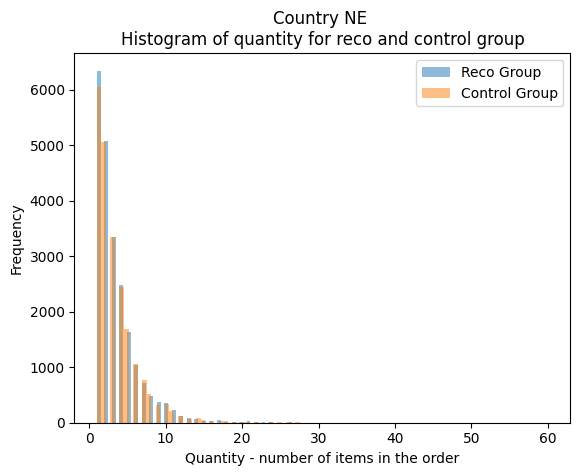

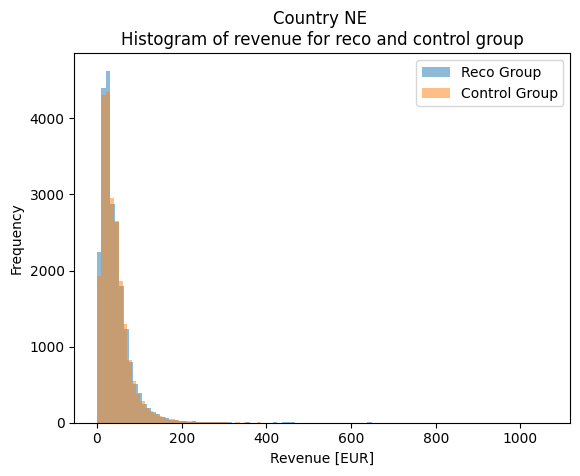

In [55]:
# NE
df_join = df_join_ne

# Histogram for quantity
plt.hist(x=df_join["quantity"][df_join["abUser"] == 1],
         bins=100,  alpha=0.5, label="reco group")
plt.hist(x=df_join["quantity"][df_join["abUser"] == 2],
         bins=100,  alpha=0.5, label="control group")
plt.xlabel("Quantity - number of items in the order")
plt.ylabel("Frequency")
plt.legend(["Reco Group", "Control Group"])
plt.title("Country NE \nHistogram of quantity for reco and control group")
plt.show()

# Histogram for revenue
plt.hist(x=df_join["revenue"][df_join["abUser"] == 1],
         bins=100,  alpha=0.5, label="reco group")
plt.hist(x=df_join["revenue"][df_join["abUser"] == 2],
         bins=100,  alpha=0.5, label="control group")
plt.xlabel("Revenue [EUR]")
plt.ylabel("Frequency")
plt.legend(["Reco Group", "Control Group"])
plt.title("Country NE \nHistogram of revenue for reco and control group")
plt.show()

##### Average item revenue by order size (NE country)

###### Due to the frequency of occurrence, I also visualized the comparison of the two groups for the most frequent number of items in the orders. 

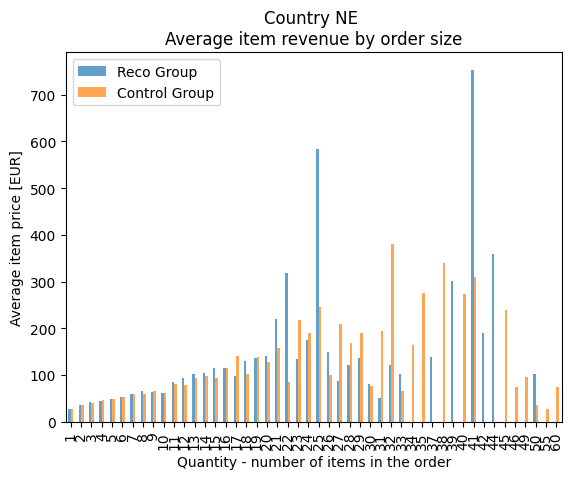

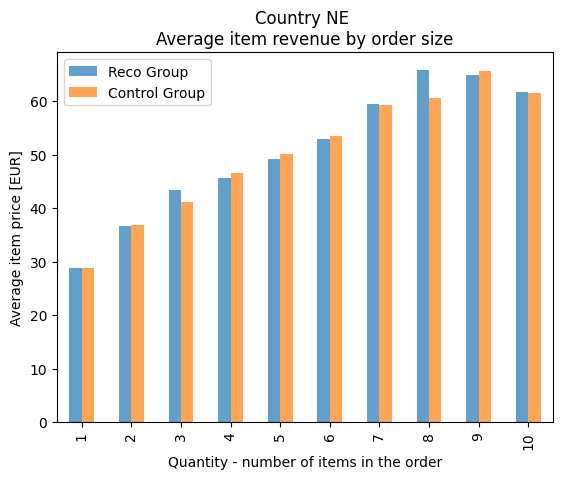

In [56]:
# Visualization of average revenue by quantity
grouped_data = df_join.groupby(["quantity", "abUser"])[
    "revenue"].mean().unstack()

ax = grouped_data.plot(kind="bar", alpha=0.7)
ax.set_title("Country NE \nAverage item revenue by order size")
ax.set_ylabel("Average item price [EUR]")
ax.set_xlabel("Quantity - number of items in the order")
plt.legend(["Reco Group", "Control Group"])
plt.show()

# Visualization of average revenue by quantity for most common quantity
filtered_df = df_join[df_join["quantity"].between(1, 10)]
grouped_data_filtered = filtered_df.groupby(["quantity", "abUser"])[
    "revenue"].mean().unstack()

ax = grouped_data_filtered.plot(kind="bar", alpha=0.7)
ax.set_title("Country NE \nAverage item revenue by order size")
ax.set_ylabel("Average item price [EUR]")
ax.set_xlabel("Quantity - number of items in the order")
plt.legend(["Reco Group", "Control Group"])
plt.show()